In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle
%matplotlib inline

# Camera calibration 

In [30]:
nx, ny = 9, 6 # Expected chessboard features (row x columns)
path_image_cal = 'camera_cal' # Folder containing images for camera calibration
name_calibration = 'calibration.p' 
images = glob.glob(path_image_cal + '/*.jpg') # Make a list of calibration images

## Collect data for camera calibration

In [23]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname) # Load the image in BGR 
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

## Do camera calibration given object points and image points

In [29]:
img_size = img.shape[:2]
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
print(mtx.shape)
print(dist.shape)


(3, 3)
(1, 5)


## Test image calibration

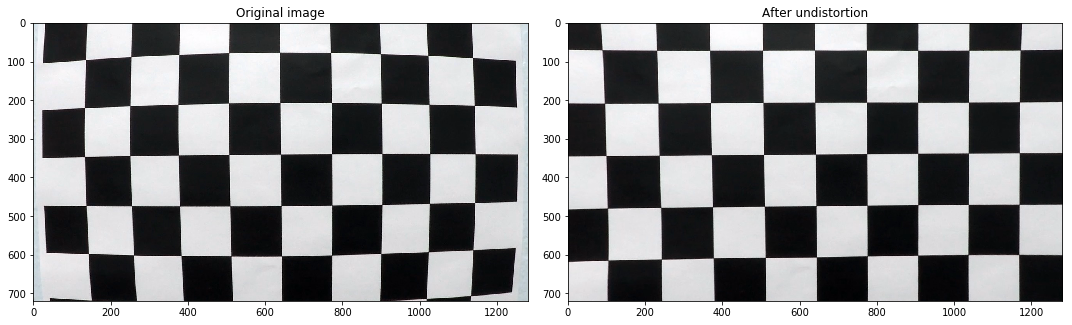

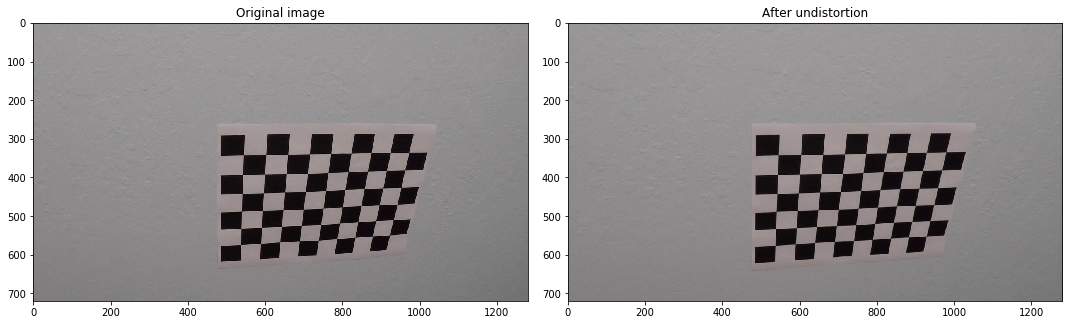

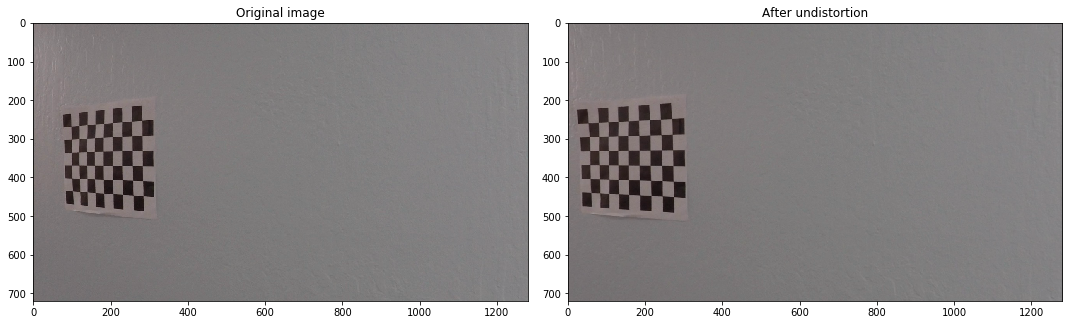

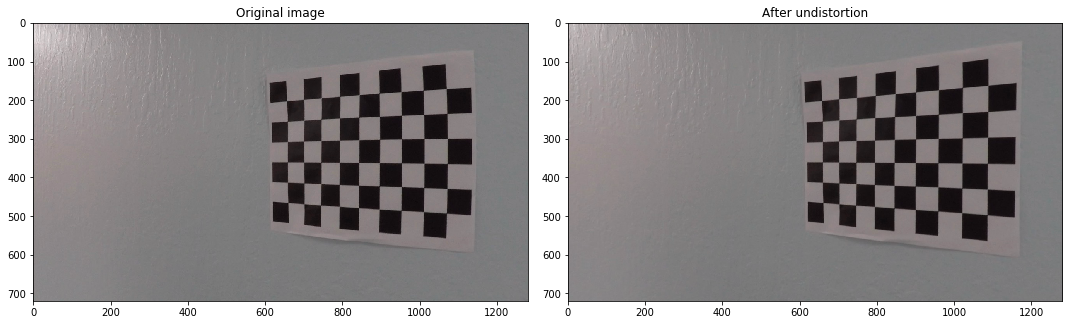

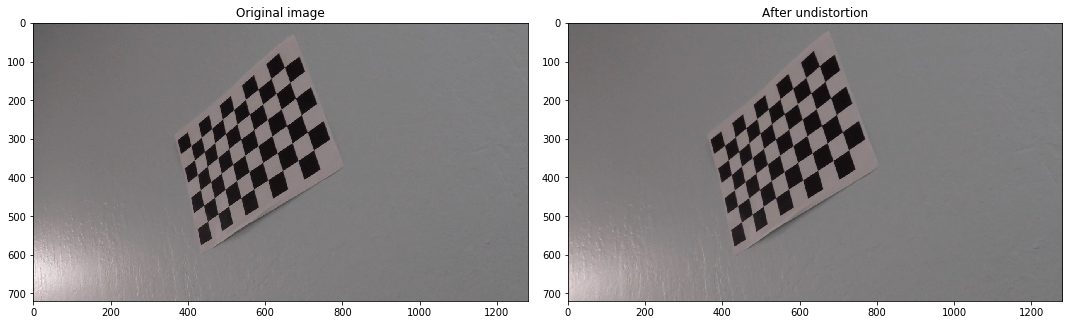

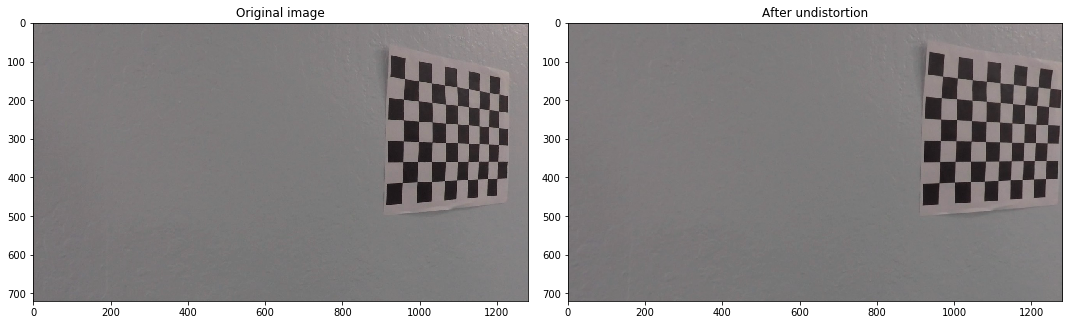

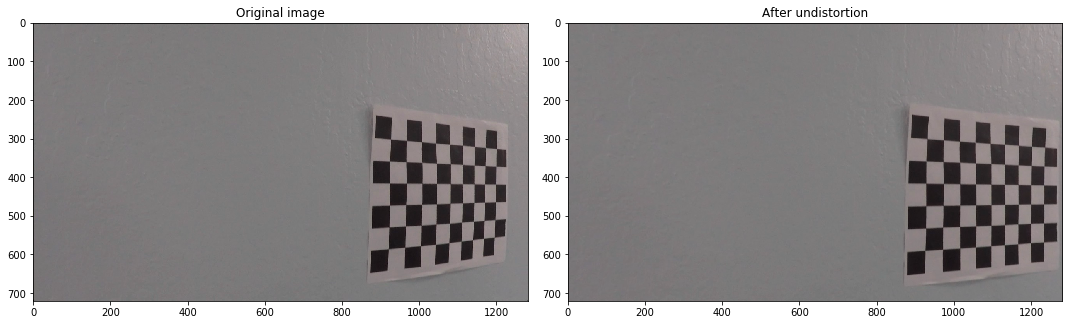

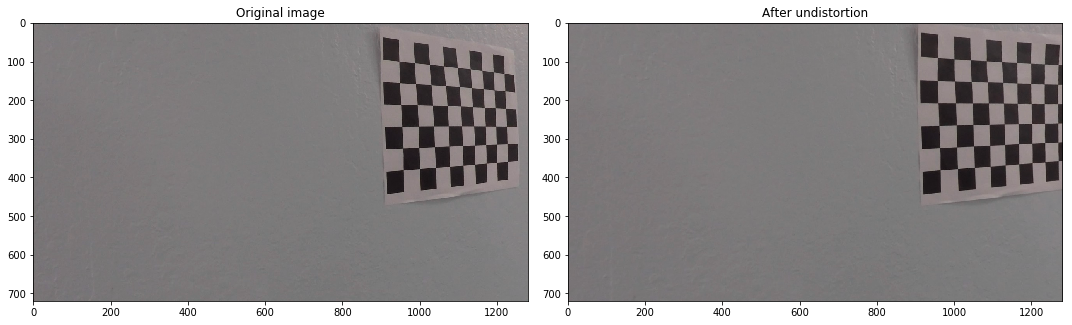

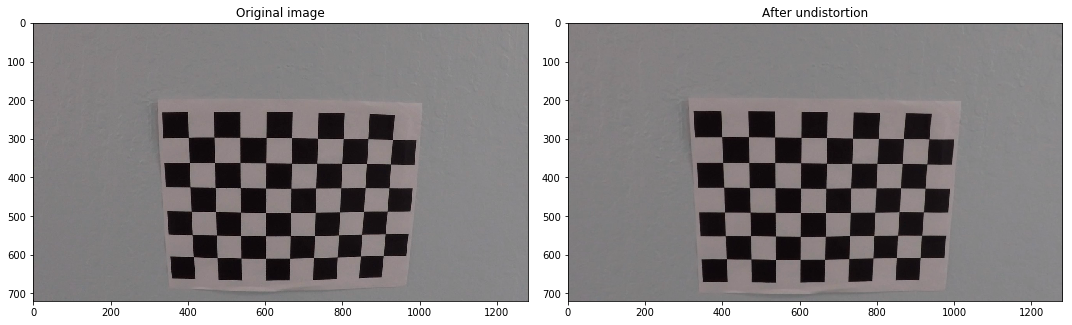

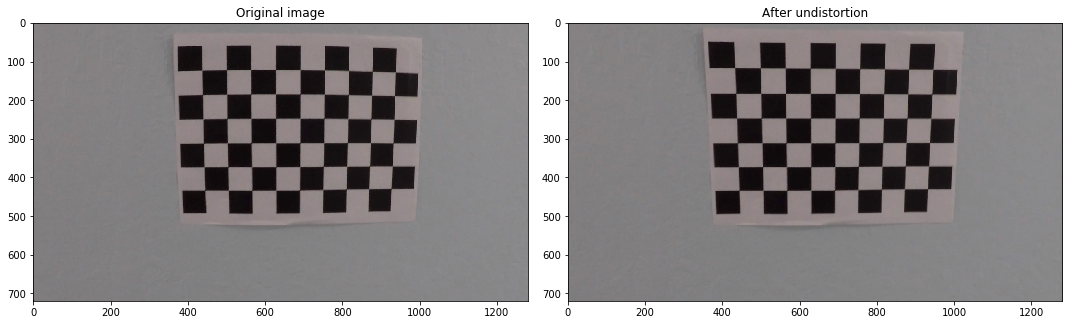

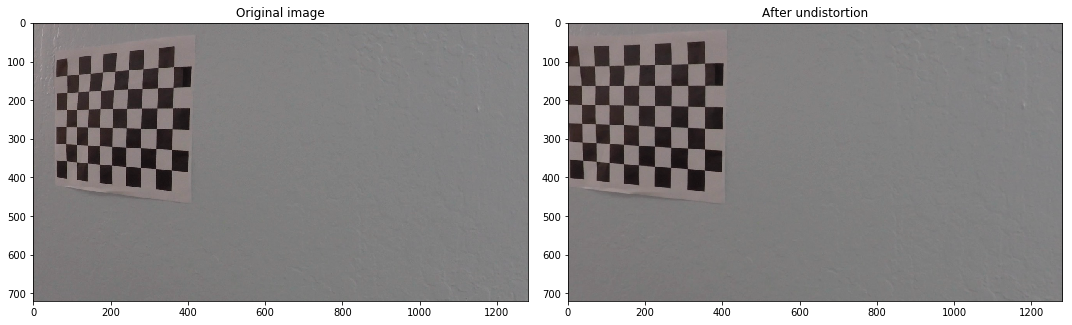

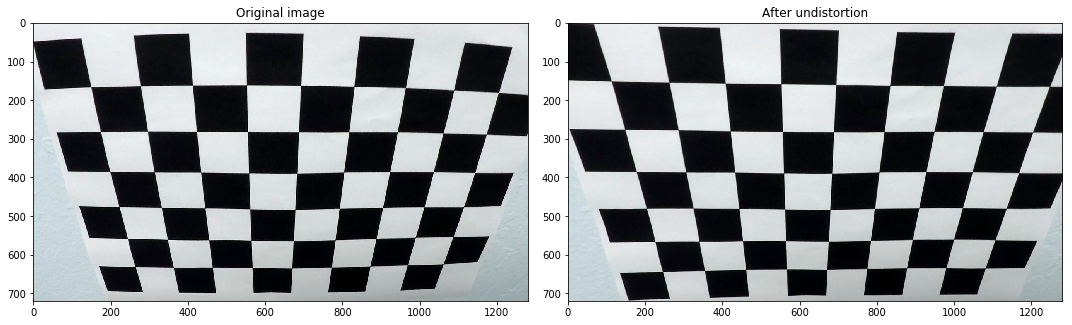

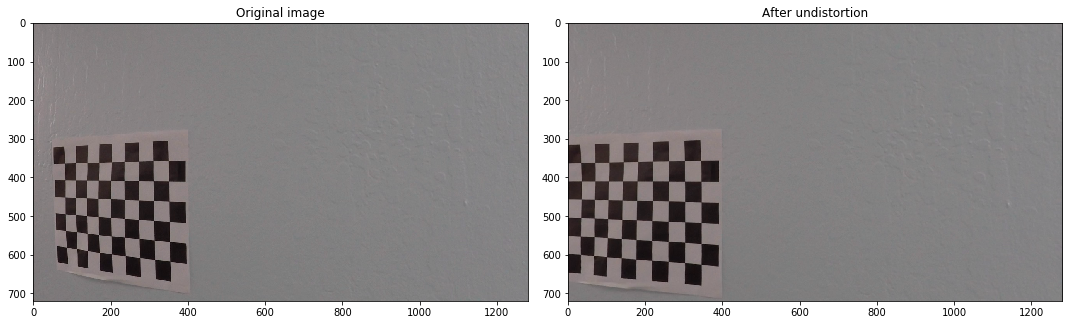

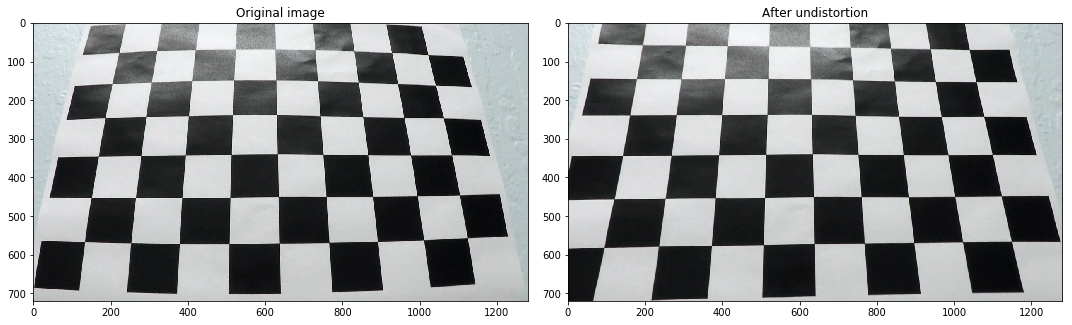

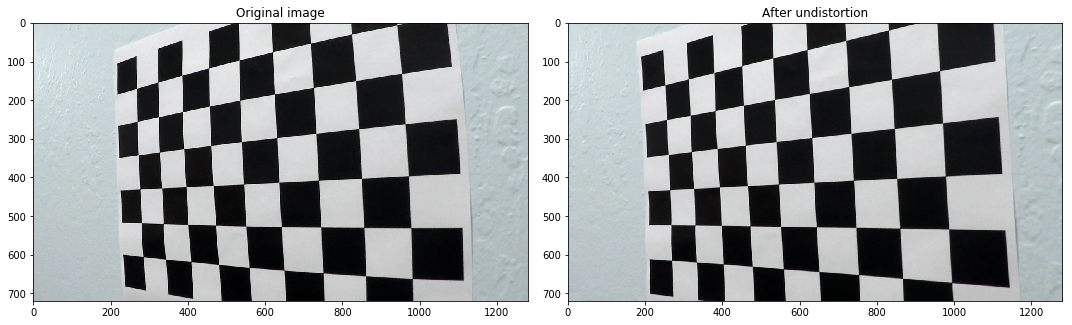

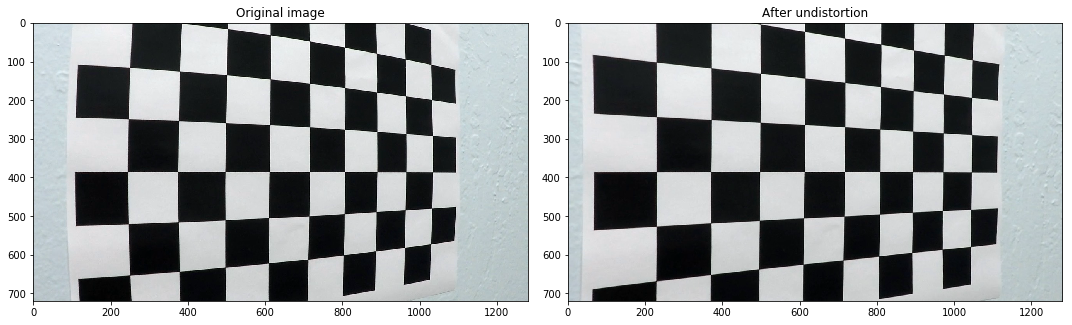

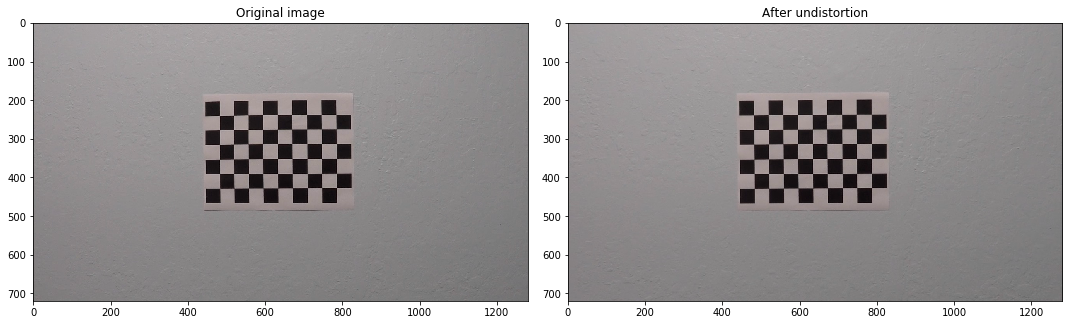

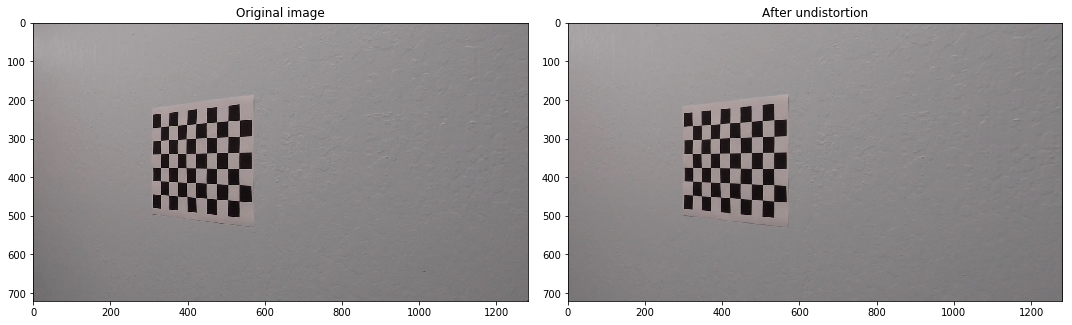

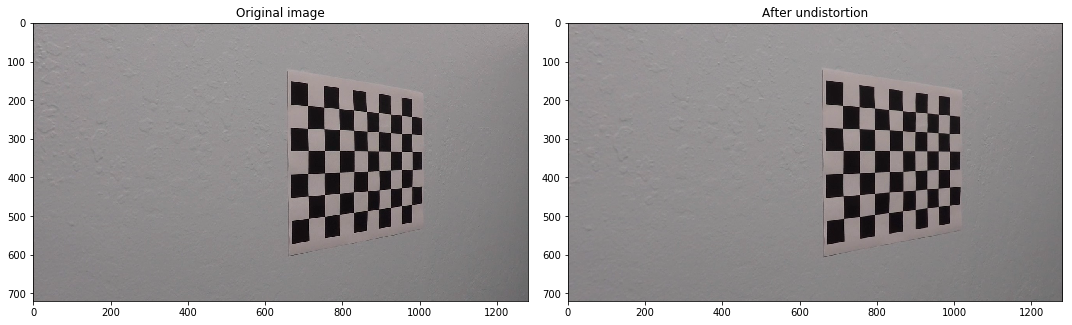

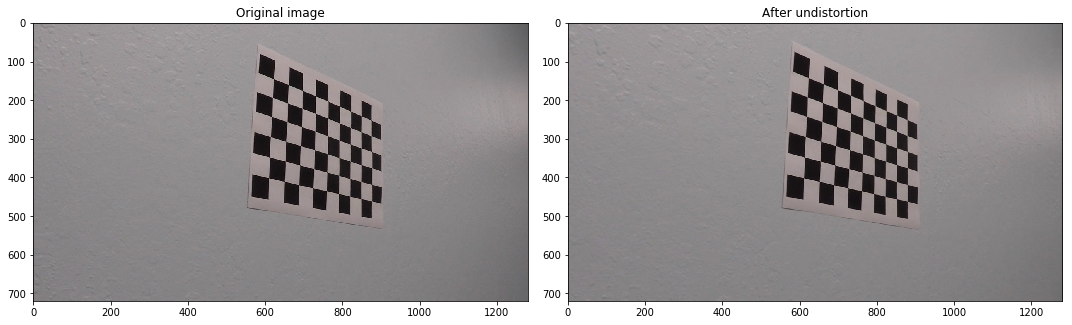

In [61]:
for idx, fname in enumerate(images):
    img = cv2.imread(fname) # Load the image in BGR 
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,30))
    # Draw original image
    ax[0].imshow(img)
    ax[0].set_title('Original image')
    # Draw image after undistortion
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    ax[1].imshow(dst)
    ax[1].set_title('After undistortion')
    f.tight_layout()
    plt.show()

## Results wrap-up

In [33]:
# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( name_calibration, "wb" ) )

In [34]:
def undistortion(img):
    '''
    This functions return the image after undistortion. Assumes that
    - mtx, camera matrix, exists in the workspace 
    - dist, distortion coefficients vector, exists in the workspace
    '''
    return cv2.undistort(img, mtx, dist, None, mtx)

# Image binarising pipeline

In [43]:
path_test_images = 'test_images'
test_images = glob.glob(path_test_images+'/*.jpg')

In [44]:
! ls test_images

straight_lines1.jpg test1.jpg           test3.jpg           test5.jpg
straight_lines2.jpg test2.jpg           test4.jpg           test6.jpg


## Pipeline for binarising image

In [70]:
# TO DO : 
# - Find better parameters
# - Find better combination ? 

# Edit this function to create your own pipeline.
def binary_pipeline(image, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(image)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    return s_binary

## Testing the pipeline

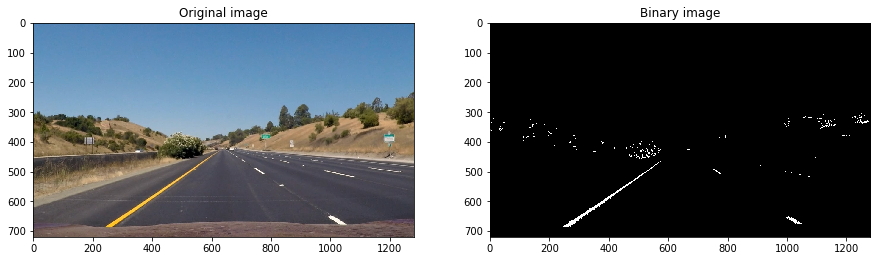

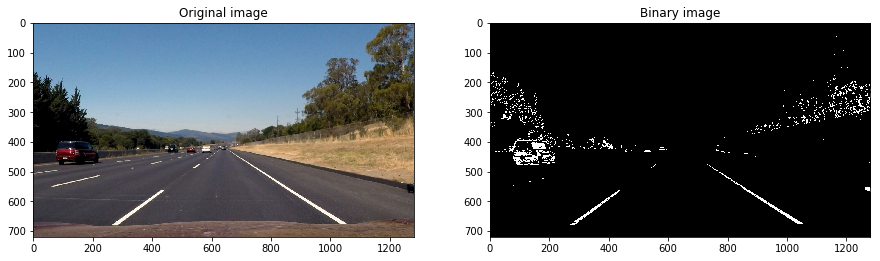

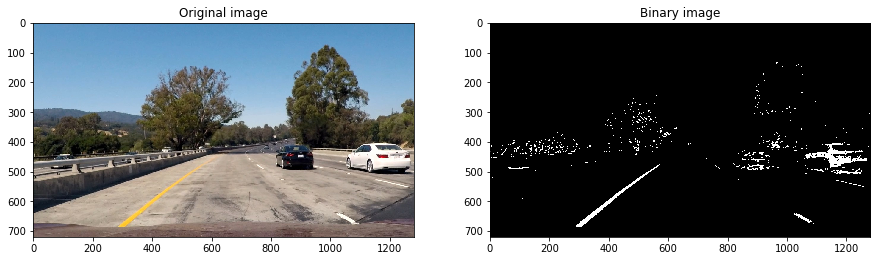

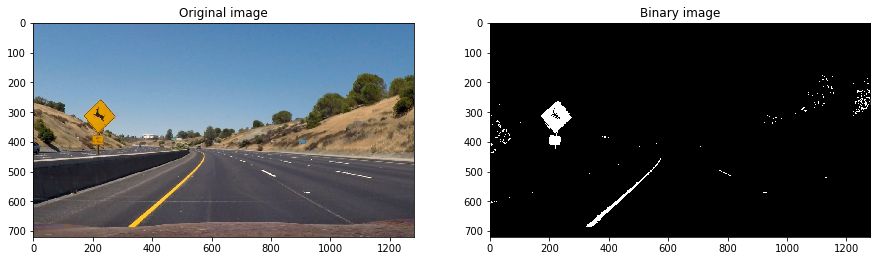

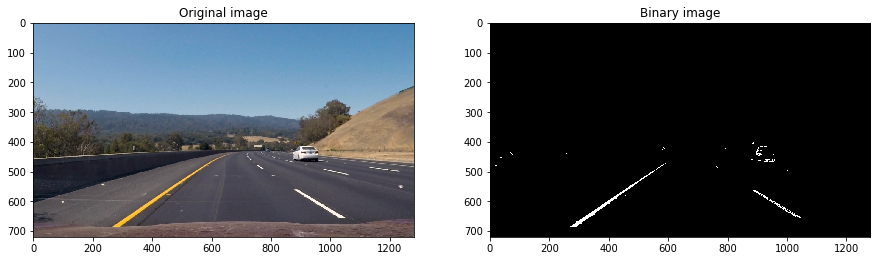

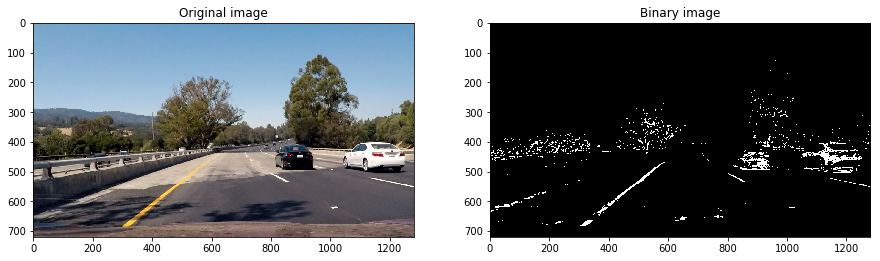

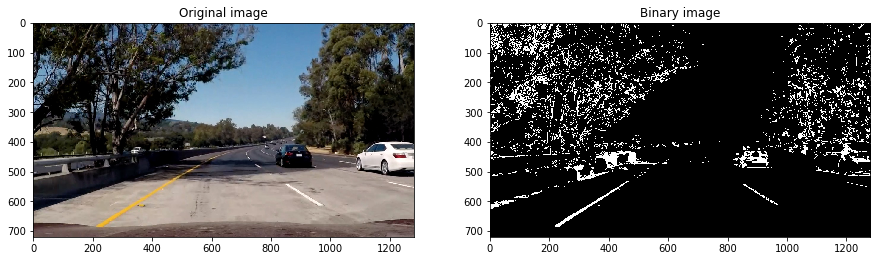

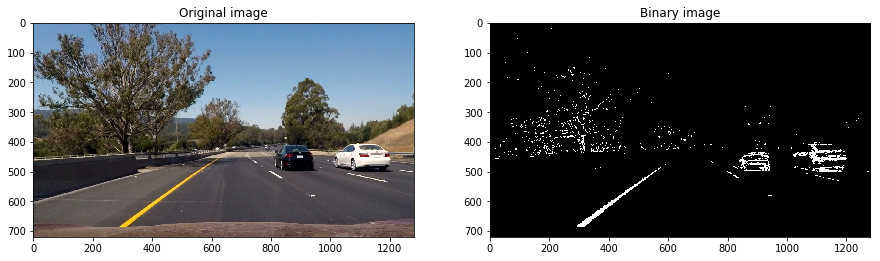

In [72]:
for fname in test_images:
    img = cv2.imread(fname)
    binary = binary_pipeline(img,s_thresh=(170, 255), sx_thresh=(20, 100))
    # Plot the result
    f, ax = plt.subplots(1, 2, figsize=(15,30))
    # Draw original image
    ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB) )
    ax[0].set_title('Original image')
    # Draw image after undistortion
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    ax[1].imshow(binary,cmap='gray')
    ax[1].set_title('Binary image')
    

# Perspective transform

In [75]:
path_straightline = 'test_images'
straightline_images = glob.glob(path_test_images+'/straight*.jpg')

In [362]:
src = np.float32([[560, 470],
                  [725, 470],
                 [1090, 690],
                  [210, 690]
                 ])

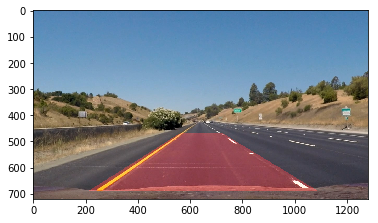

In [363]:
% matplotlib inline
raw = cv2.cvtColor(cv2.imread(straightline_images[0]),cv2.COLOR_BGR2RGB)
undist = undistortion(raw)
msk = np.zeros_like(undist)
cv2.fillPoly(msk,np.int_([src]),color = [255, 0, 0])
to_plot = cv2.addWeighted(raw,1,msk,0.3,0)
plt.imshow(to_plot)

In [364]:
offset = 0
img_size = img.shape[:2]
dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])

In [369]:
# Given src and dst points, calculate the perspective transform matrix
M = cv2.getPerspectiveTransform(src, dst)
# Warp the image using OpenCV warpPerspective()
warped = cv2.warpPerspective(undist, M, img_size)

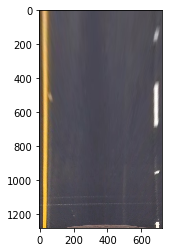

In [366]:
plt.imshow(warped)

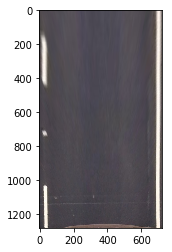

In [367]:
raw = cv2.cvtColor(cv2.imread(straightline_images[1]),cv2.COLOR_BGR2RGB)
undist = undistortion(raw)
warped = cv2.warpPerspective(undist, M, img_size)
plt.imshow(warped)

In [370]:
# Load our image
binary_warped = binary_pipeline(warped)

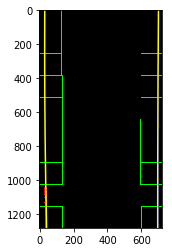

In [371]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 10
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    print(lef)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img


out_img = fit_polynomial(binary_warped)

plt.imshow(out_img)

In [368]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None